In [13]:
# Koidlala Surya Prakash
# EE18BTECH11026


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sympy import Matrix, init_printing
random.seed(40)

## Problem 01

In [2]:
class MLP :
    def __init__(self,input_nodes = 2, hidden_nodes = 2, output_nodes = 1):

        ### dimensions  = 2
        self.din = input_nodes
        self.m = hidden_nodes
        self.k = output_nodes

        #### H -> hidden nodes output
        #### W_h -> weights between input and hidden layer
        #### W_o -> weights between hidden and output layer
        
        ## initialising random weights
        self.W_h = np.random.random((self.din+1,self.m+1))
        self.W_o = np.random.random((self.m +1, self.k))

        
    def forward_pass(self,X):

        def sigmoid (w,x) :
            act = np.transpose(w)@x
            return 1/(1+np.exp(-1*act))
        
        #####################################
        X_with_bias = np.ones((X.shape[0]+1, X.shape[1]))
        X_with_bias[1:][:] = X
        X = X_with_bias
        
        self.H = sigmoid(self.W_h,X)
        self.H[0,:] = np.ones(self.H[0,:].shape)  ### resetting bias to 1

        self.Y_pred = sigmoid(self.W_o,self.H) 
        return self.Y_pred
        
    @staticmethod
    def output_loss(y,y_hat):
        return (-1*(y - y_hat))

    @staticmethod
    def sig_loss(y_hat):
        return np.multiply((1 - y_hat) , (y_hat))
        
    def back_prop(self,X,Y):
        '''
        Iteratively updates each weight
        '''
        X_with_bias = np.ones((X.shape[0]+1, X.shape[1]))
        X_with_bias[1:][:] = X
        X = X_with_bias
        #### Back prop : 
        W_o_grad = self.W_o.copy()
        W_h_grad = self.W_h.copy()
        W_o_new = self.W_o.copy()
        W_h_new = self.W_h.copy()
        lr = self.lr
        
        #### Updating output weights : 
        for i in range(W_o_grad.shape[0]):
            for j in range(W_o_grad.shape[1]):
                W_o_grad[i][j] = np.sum( self.output_loss(Y[j],self.Y_pred[j]) * self.sig_loss(self.Y_pred[j]) * self.H[i] )
                W_o_new[i][j] = self.W_o[i][j] - (lr* W_o_grad[i][j] ) 
                
        ##### Updating input weights:
        k = 0   
        for i in range(W_h_grad.shape[0]):
            for j in range(W_h_grad.shape[1]):
                W_h_grad[i][j] = np.sum( self.output_loss(Y[k],self.Y_pred[k]) * self.sig_loss(self.Y_pred[k]) * self.W_o[j][k] * self.sig_loss(self.H[j]) * X[i] )
                W_h_new[i][j] = self.W_h[i][j] - ( lr*W_h_grad[i][j] )
                
        self.W_h, self.W_o = W_h_new, W_o_new
        
        
    def train(self,X,Y):
        '''
         forward pass --> returns error and updates parameter
        '''
        
        self.forward_pass(X)
        err =  np.mean((Y - self.Y_pred)**2)
        self.back_prop(X,Y)
        return err
    
    def test(self,X_tst,Y_tst):
        self.forward_pass(X_tst)
        error = np.mean(( (Y_tst - self.Y_pred) **2))
        return error
    
    @staticmethod
    def split_train_val(X,Y, train_percent):
        n = X.shape[1]
        X_train,X_val = X[:,:int(train_percent*n)], X[:,int(train_percent*n) :]
        Y_train,Y_val = Y[:,:int(train_percent*n)], Y[:,int(train_percent*n) :]
        return X_train, X_val , Y_train, Y_val
    
    @staticmethod
    def split_into_batches(X,Y,bs):
        '''
        returns a list of batches
        '''

        samples_no = X.shape[1]
        #print(samples_no)
        X_batches = []
        Y_batches = []

        idx_permute = list(np.random.permutation(samples_no))
        no_of_batches = samples_no/bs

        if(no_of_batches %1 != 0):
            print('Enter valid bs -- that can divide the %d evenly' %(samples_no))

        else:
            for i in range(0, samples_no, bs):
                #print(i)
                batch_index = idx_permute[i:i+bs]
                #print(batch_index)
                X_batch = X[:,batch_index]
                Y_batch = Y[:, batch_index]

                X_batches.append(X_batch)
                Y_batches.append(Y_batch)
        return X_batches, Y_batches
    
    def run_epochs(self,X,Y, epochs, bs, lr, train_val_ratio = 0.8, plot = False):
        '''
        for each epoch : Splits the train data into batches each of batch size 
        finds the error both on test and train 
        backpropagates
        plots the er
        '''
        self.lr= lr
        trn_epoch_error = np.zeros(epochs)
        tst_epoch_error = np.zeros(epochs)
        
        ### splitting into train and validation set
        X_train, X_tst, Y_train, Y_tst = self.split_train_val(X,Y,train_val_ratio)
        
        for e in range(epochs):
            X_batches, Y_batches = self.split_into_batches(X_train, Y_train, bs) ### Batch grad descent
            batch_err_list = []
            
            for b_id in range(len(X_batches)):
                X_b, Y_b = X_batches[b_id], Y_batches[b_id]
                batch_err = self.train(X_b,Y_b)
                batch_err_list.append(batch_err)
            trn_epoch_error[e] = np.mean(batch_err_list)
            
            ### testing..
            tst_epoch_error[e] = self.test(X_tst,Y_tst)
            
        if(plot ==True):
            epoch_no= np.arange(len(trn_epoch_error))
            plt.xlabel('Epochs')
            plt.ylabel('Squared loss')
            plt.plot(epoch_no,trn_epoch_error, label = 'train error')
            plt.plot(epoch_no,tst_epoch_error,label = 'test error')
            plt.title('Train vs test loss during training\n epochs : %d , lr :%.2f, bs : %d'%(epochs, lr, bs))
            plt.legend()
            plt.figure()
            plt.show()


In [3]:
'''
Code for creating dataset , var of 0.05 is used
'''
def create_XOR_data(data_size,var, plot = True):
    
    A = np.random.binomial(size = data_size, n=1, p= 0.5)
    B = np.random.binomial(size = data_size, n=1, p= 0.5)
    X = np.array((A,B))
    Y = np.logical_xor(X[0],X[1]) + 0
    
    
    color = ['black'*(1-i) + 'cyan'*(i) for i in (Y) ]
    
    X_noise= X + np.random.normal(0, var, X.shape)
    Y_final = Y.reshape((1,Y.shape[0]))
    
    ### plotting : 
    if(plot):
        plt.scatter(X_noise[0],X_noise[1],color = color)
        plt.title('Visualizing dataset: N ={} , sig = {} \n A XOR B : cyan : 0 , black : 1'.format(data_size, var))
        plt.xlabel('A (with noise)')
        plt.ylabel('B (with noise)')
        plt.figure()
        plt.show()
        
    return X_noise,Y_final



def create_AND_data(data_size,var, plot = True):
    
    A = np.random.binomial(size = data_size, n=1, p= 0.5)
    B = np.random.binomial(size = data_size, n=1, p= 0.5)
    X = np.array((A,B))
    Y = np.logical_and(X[0],X[1]) + 0
    
    
    color = ['black'*(1-i) + 'cyan'*(i) for i in (Y) ]
    
    X_noise= X + np.random.normal(0, var, X.shape)
    Y_final = Y.reshape((1,Y.shape[0]))
    
    ### plotting : 
    if(plot):
        plt.scatter(X_noise[0],X_noise[1],color = color)
        plt.title('Visualizing dataset: N ={} , sig = {} \n A AND B: cyan : 0 , black : 1'.format(data_size, var))
        
        plt.xlabel('A (with noise)')
        plt.ylabel('B (with noise)')
        plt.figure()
        plt.show()
    
    return X_noise,Y_final


def create_OR_data(data_size,var, plot = True):
    
    A = np.random.binomial(size = data_size, n=1, p= 0.5)
    B = np.random.binomial(size = data_size, n=1, p= 0.5)
    X = np.array((A,B))
    Y = np.logical_or(X[0],X[1]) + 0
    
    color = ['black'*(1-i) + 'cyan'*(i) for i in (Y) ]
    
    X_noise= X + np.random.normal(0, var, X.shape)
    Y_final = Y.reshape((1,Y.shape[0]))
    
    ### plotting : 
    if(plot):
        plt.scatter(X_noise[0],X_noise[1],color = color)
        plt.title('Visualizing dataset: N ={} , sig = {} \n A OR B \n: cyan : 0 , black : 1'.format(data_size, var))
        plt.xlabel('A (with noise)')
        plt.ylabel('B (with noise)')
        plt.figure()
        plt.show()
    
    return X_noise,Y_final

# XOR 

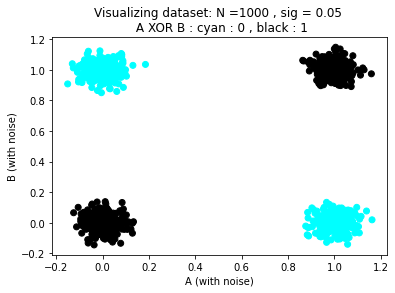

<Figure size 432x288 with 0 Axes>

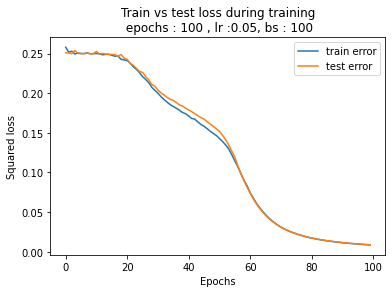

<Figure size 432x288 with 0 Axes>

------------------- Parameters after 100 epochs training ------------- 

------  W_h ------
[[-2.79887025  6.31670585  6.37377164]
 [ 5.79641999 -3.82821829 -3.93921143]]

------  W_O ------
[[-9.03916817]
 [ 6.13572095]
 [ 6.31310659]]
-------------------  INFERENCE ------------------
A :1.02 B :0.93 --> A XOR B : 0.12 --> rounded: 0 
A :1.01 B :-0.03 --> A XOR B : 0.92 --> rounded: 1 
A :1.03 B :1.07 --> A XOR B : 0.09 --> rounded: 0 
A :-0.01 B :-0.05 --> A XOR B : 0.08 --> rounded: 0 


In [4]:
np.random.seed(100) #### Seeding for consistent results ..
X_XOR, Y_XOR = create_XOR_data(1000, 0.05)
XOR_model = MLP()
XOR_model.run_epochs(X_XOR,Y_XOR, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()
print('------------------- Parameters after 100 epochs training ------------- ')

print('\n------  W_h ------')
print( (XOR_model.W_h).T[1:][:])

print('\n------  W_O ------')
print(XOR_model.W_o)



print('-------------------  INFERENCE ------------------')
#### Inference :

for i in range(4):
    X_XOR_test,_ = create_XOR_data(1, 0.05, plot = False)
    print('A :{:.2f} B :{:.2f} --> A XOR B : {:.2f} --> rounded: {} '.format(X_XOR_test[0][0],X_XOR_test[1][0], XOR_model.forward_pass(X_XOR_test )[0][0], round(XOR_model.forward_pass(X_XOR_test )[0][0]) ) )
    

## Varying N 

-------------------  N = 1000 ------------------


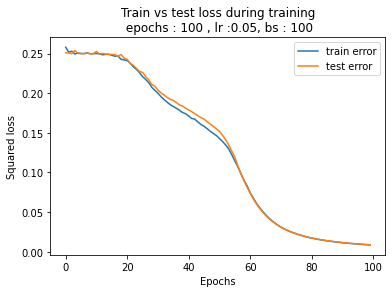

<Figure size 432x288 with 0 Axes>

-------------------  N = 2500 ------------------


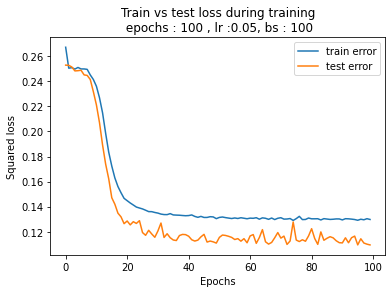

<Figure size 432x288 with 0 Axes>

-------------------  N = 5000 ------------------


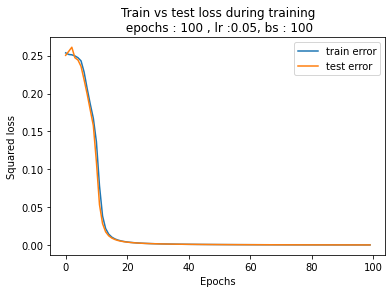

<Figure size 432x288 with 0 Axes>

In [5]:
np.random.seed(100) #### Seeding for consistent results ..


print('-------------------  N = 1000 ------------------')
X_XOR, Y_XOR = create_XOR_data(1000, 0.05, plot = False)
XOR_model = MLP()
XOR_model.run_epochs(X_XOR,Y_XOR, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()

print('-------------------  N = 2500 ------------------')
X_XOR, Y_XOR = create_XOR_data(2500, 0.05, plot = False)
XOR_model = MLP()
XOR_model.run_epochs(X_XOR,Y_XOR, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()

print('-------------------  N = 5000 ------------------')
X_XOR, Y_XOR = create_XOR_data(5000, 0.05, plot = False)
XOR_model = MLP()
XOR_model.run_epochs(X_XOR,Y_XOR, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()


### Varying lr

-------------------  lr = 0.0001 ------------------


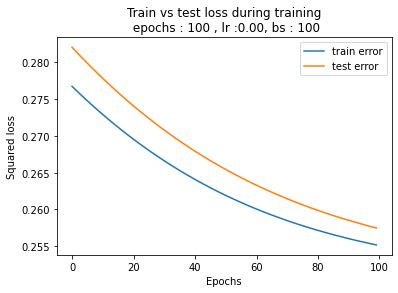

<Figure size 432x288 with 0 Axes>

-------------------  lr = 0.05  ------------------


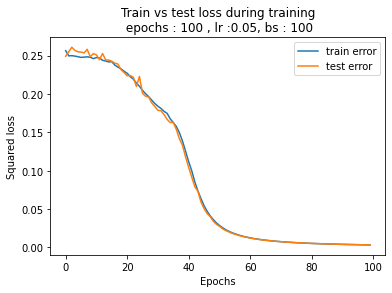

<Figure size 432x288 with 0 Axes>

-------------------  lr = 0.1 ------------------


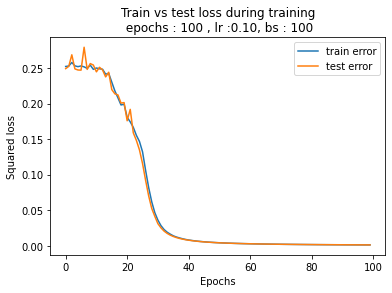

<Figure size 432x288 with 0 Axes>

In [6]:
np.random.seed(100) #### Seeding for consistent results ..


print('-------------------  lr = 0.0001 ------------------')
X_XOR, Y_XOR = create_XOR_data(1000, 0.05, plot = False)
XOR_model = MLP()
XOR_model.run_epochs(X_XOR,Y_XOR, epochs = 100, bs = 100 , lr = 0.0001, train_val_ratio = 0.8, plot = True)
plt.show()

print('-------------------  lr = 0.05  ------------------')
X_XOR, Y_XOR = create_XOR_data(1000, 0.05, plot = False)
XOR_model = MLP()
XOR_model.run_epochs(X_XOR,Y_XOR, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()

print('-------------------  lr = 0.1 ------------------')
X_XOR, Y_XOR = create_XOR_data(1000, 0.05, plot = False)
XOR_model = MLP()
XOR_model.run_epochs(X_XOR,Y_XOR, epochs = 100, bs = 100 , lr = 0.1, train_val_ratio = 0.8, plot = True)
plt.show()


## AND

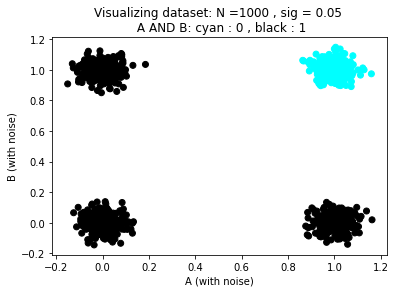

<Figure size 432x288 with 0 Axes>

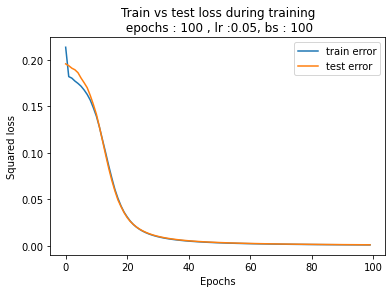

<Figure size 432x288 with 0 Axes>

------------------- WEIGHTS after 100 epochs training ------------- 

------  W_h ------
[[-2.47859998  1.58706061  1.81647362]
 [-5.32751459  3.56638527  3.53285404]]

------  W_O ------
[[-5.40849565]
 [ 2.88943033]
 [ 7.5537479 ]]
-------------------  INFERENCE ------------------
A :1.02 B :0.93 --> A AND B : 0.95 --> rounded: 1 
A :1.01 B :-0.03 --> A AND B : 0.03 --> rounded: 0 
A :1.03 B :1.07 --> A AND B : 0.97 --> rounded: 1 
A :-0.01 B :-0.05 --> A AND B : 0.01 --> rounded: 0 


In [7]:
np.random.seed(100)#### Seeding for consistent results ..
X_AND, Y_AND = create_AND_data(1000, 0.05)
AND_model = MLP()
AND_model.run_epochs(X_AND,Y_AND, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()

print('------------------- WEIGHTS after 100 epochs training ------------- ')

print('\n------  W_h ------')
print( (AND_model.W_h).T[1:][:])

print('\n------  W_O ------')
print(AND_model.W_o)

print('-------------------  INFERENCE ------------------')
#### Inference :

for i in range(4):
    X_AND_test,_ = create_AND_data(1, 0.05, plot = False)
    print('A :{:.2f} B :{:.2f} --> A AND B : {:.2f} --> rounded: {} '.format(X_AND_test[0][0],X_AND_test[1][0], AND_model.forward_pass(X_AND_test )[0][0], round(AND_model.forward_pass(X_AND_test )[0][0]) ) )
    

## Varying N 

-------------------  N = 1000 ------------------


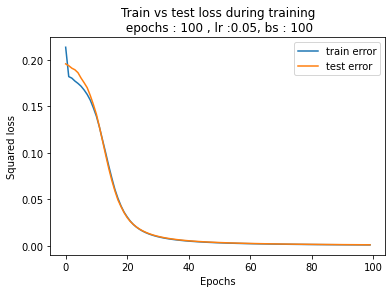

<Figure size 432x288 with 0 Axes>

-------------------  N = 2500 ------------------


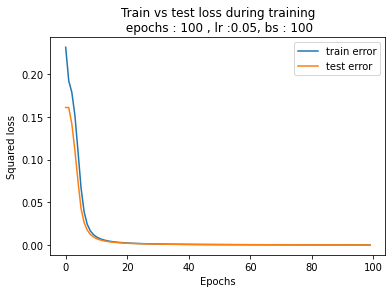

<Figure size 432x288 with 0 Axes>

-------------------  N = 5000 ------------------


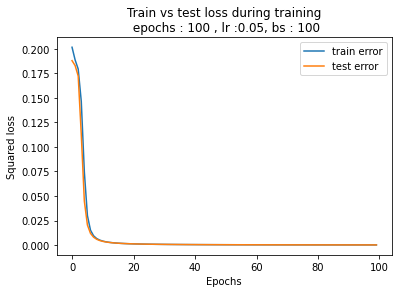

<Figure size 432x288 with 0 Axes>

In [8]:
np.random.seed(100) #### Seeding for consistent results ..


print('-------------------  N = 1000 ------------------')
X_AND, Y_AND = create_AND_data(1000, 0.05, plot = False)
AND_model = MLP()
AND_model.run_epochs(X_AND,Y_AND, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()

print('-------------------  N = 2500 ------------------')
X_AND, Y_AND = create_AND_data(2500, 0.05, plot = False)
AND_model = MLP()
AND_model.run_epochs(X_AND,Y_AND, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()

print('-------------------  N = 5000 ------------------')
X_AND, Y_AND = create_AND_data(5000, 0.05, plot = False)
AND_model = MLP()
AND_model.run_epochs(X_AND,Y_AND, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()

### Varying lr

-------------------  lr = 0.0001 ------------------


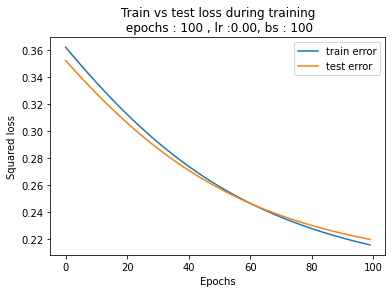

<Figure size 432x288 with 0 Axes>

-------------------  lr = 0.05  ------------------


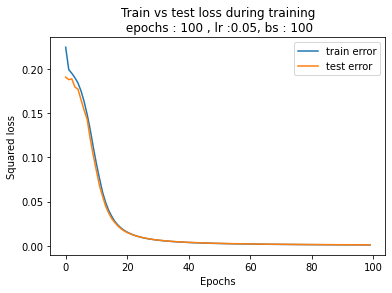

<Figure size 432x288 with 0 Axes>

-------------------  lr = 0.1 ------------------


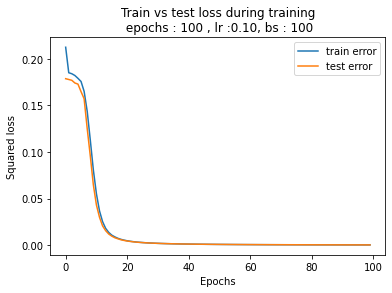

<Figure size 432x288 with 0 Axes>

In [9]:

np.random.seed(100) #### Seeding for consistent results ..


print('-------------------  lr = 0.0001 ------------------')
X_AND, Y_AND = create_AND_data(1000, 0.05, plot = False)
AND_model = MLP()
AND_model.run_epochs(X_AND,Y_AND, epochs = 100, bs = 100 , lr = 0.0001, train_val_ratio = 0.8, plot = True)
plt.show()

print('-------------------  lr = 0.05  ------------------')
X_AND, Y_AND = create_AND_data(1000, 0.05, plot = False)
AND_model = MLP()
AND_model.run_epochs(X_AND,Y_AND, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()

print('-------------------  lr = 0.1 ------------------')
X_AND, Y_AND = create_AND_data(1000, 0.05, plot = False)
AND_model = MLP()
AND_model.run_epochs(X_AND,Y_AND, epochs = 100, bs = 100 , lr = 0.1, train_val_ratio = 0.8, plot = True)
plt.show()


## OR

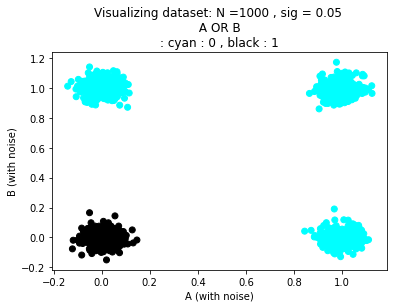

<Figure size 432x288 with 0 Axes>

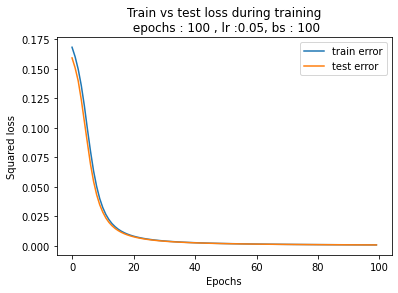

<Figure size 432x288 with 0 Axes>

------------------- WEIGHTS after 100 epochs training ------------- 

------  W_h ------
[[-2.15276903  3.93862228  4.06464495]
 [-1.66719149  2.98844754  2.94417734]]

------  W_O ------
[[-4.45227597]
 [ 6.03507132]
 [ 3.94430867]]
-------------------  INFERENCE ------------------
A :1.06 B :0.01 --> A OR B : 0.98 --> rounded: 1 
A :1.00 B :1.00 --> A OR B : 1.00 --> rounded: 1 
A :1.03 B :0.02 --> A OR B : 0.98 --> rounded: 1 
A :0.01 B :-0.06 --> A OR B : 0.03 --> rounded: 0 


In [10]:
np.random.seed(0)#### Seeding for consistent results ..
X_OR, Y_OR = create_OR_data(1000, 0.05)
OR_model = MLP()
OR_model.run_epochs(X_OR,Y_OR, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()

print('------------------- WEIGHTS after 100 epochs training ------------- ')

print('\n------  W_h ------')
print( (OR_model.W_h).T[1:][:])

print('\n------  W_O ------')
print(OR_model.W_o)

print('-------------------  INFERENCE ------------------')
#### Inference :

for i in range(4):
    X_OR_test,_ = create_OR_data(1, 0.05, plot = False)
    print('A :{:.2f} B :{:.2f} --> A OR B : {:.2f} --> rounded: {} '.format(X_OR_test[0][0],X_OR_test[1][0], OR_model.forward_pass(X_OR_test )[0][0], round(OR_model.forward_pass(X_OR_test )[0][0]) ) )
    

## Varying N 

-------------------  N = 1000 ------------------


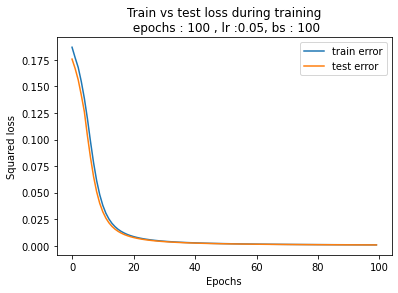

<Figure size 432x288 with 0 Axes>

-------------------  N = 2500 ------------------


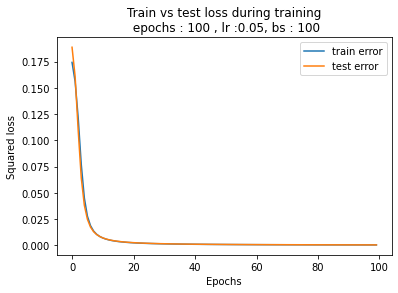

<Figure size 432x288 with 0 Axes>

-------------------  N = 5000 ------------------


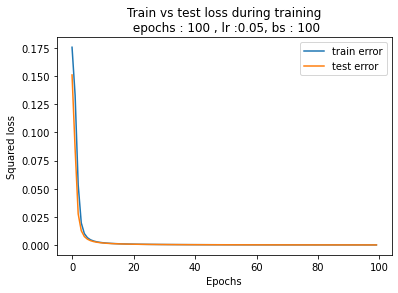

<Figure size 432x288 with 0 Axes>

In [11]:
np.random.seed(100) #### Seeding for consistent results ..


print('-------------------  N = 1000 ------------------')
X_OR, Y_OR = create_OR_data(1000, 0.05, plot = False)
OR_model = MLP()
OR_model.run_epochs(X_OR,Y_OR, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()

print('-------------------  N = 2500 ------------------')
X_OR, Y_OR = create_OR_data(2500, 0.05, plot = False)
OR_model = MLP()
OR_model.run_epochs(X_OR,Y_OR, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()

print('-------------------  N = 5000 ------------------')
X_OR, Y_OR = create_OR_data(5000, 0.05, plot = False)
OR_model = MLP()
OR_model.run_epochs(X_OR,Y_OR, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()

### Varying lr

-------------------  lr = 0.0001 ------------------


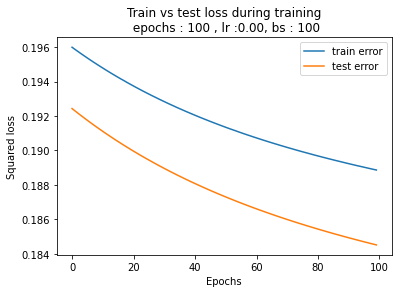

<Figure size 432x288 with 0 Axes>

-------------------  lr = 0.05  ------------------


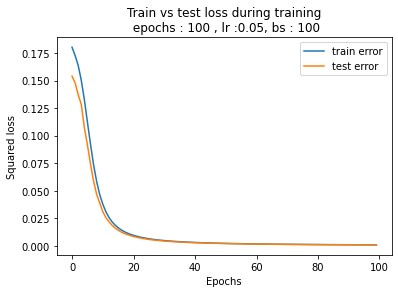

<Figure size 432x288 with 0 Axes>

-------------------  lr = 0.1 ------------------


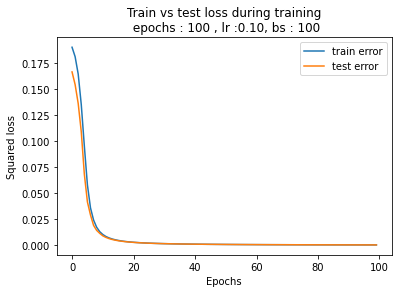

<Figure size 432x288 with 0 Axes>

In [12]:

np.random.seed(100) #### Seeding for consistent results ..


print('-------------------  lr = 0.0001 ------------------')
X_OR, Y_OR = create_OR_data(1000, 0.05, plot = False)
OR_model = MLP()
OR_model.run_epochs(X_OR,Y_OR, epochs = 100, bs = 100 , lr = 0.0001, train_val_ratio = 0.8, plot = True)
plt.show()

print('-------------------  lr = 0.05  ------------------')
X_OR, Y_OR = create_OR_data(1000, 0.05, plot = False)
OR_model = MLP()
OR_model.run_epochs(X_OR,Y_OR, epochs = 100, bs = 100 , lr = 0.05, train_val_ratio = 0.8, plot = True)
plt.show()

print('-------------------  lr = 0.1 ------------------')
X_OR, Y_OR = create_OR_data(1000, 0.05, plot = False)
OR_model = MLP()
OR_model.run_epochs(X_OR,Y_OR, epochs = 100, bs = 100 , lr = 0.1, train_val_ratio = 0.8, plot = True)
plt.show()


## observations....

# THE END 